<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/PricePred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import cupy as cp
import time
from copy import copy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
import datetime
import torch
from torch import optim
from torch import nn

AUTO = tf.data.experimental.AUTOTUNE

# Read and transform data

In [0]:
data = pd.read_excel('https://drive.google.com/uc?export=download&id=1BTjcgqQO-NxpcIRyQu2_FNxUSBCvJt7c')

In [0]:
df = data.drop(['Kundenname'], axis=1)

In [0]:
def encode(df, column):
  df[column] = df[column].astype('category')
  df[column + "_cat"] = df[column].cat.codes

In [0]:
def encode_labels(df):
  labels_to_encode = ["Auftrags-ID", "Kunden-ID", "Bestelldatum", "Produkt-ID"]
  df = df.sort_values(by=["Bestelldatum"])

  for label in labels_to_encode:
    encode(df, label)

  labels_to_encode = ["Land/Region", "Bundesland", "Stadt"]
  df = df.sort_values(by=labels_to_encode)

  for label in labels_to_encode:
    encode(df, label)

  df = df.drop(["Auftrags-ID", "Kunden-ID", "Bestelldatum",
             "Land/Region", "Bundesland", "Stadt", "Versanddatum", 
             "Produkt-ID", "Zeilen-ID"], axis=1)
  return df

In [0]:
def get_separated_entities(df):
  df = encode_labels(df)

  items = df.drop(columns=["Kunden-ID_cat", "Bestelldatum_cat", "Auftrags-ID_cat", 
                "Land/Region_cat", "Bundesland_cat", "Stadt_cat", "Region", 
                "Segment", "Versandmodus"], axis=1)
  items = pd.get_dummies(items, columns=["Kategorie" , "Unterkategorie"])
  
  transactions = pd.get_dummies(df, columns=["Segment", "Versandmodus", "Region", "Kategorie"]).drop("Produktname", axis=1)

  customers = df.drop(columns=["Versandmodus", "Produktname", "Kategorie", "Gewinn",
                             "Bestelldatum_cat", "Produkt-ID_cat", "Kunden-ID_cat", "Unterkategorie"], axis=1)
  customers = pd.get_dummies(customers, columns=["Segment", "Region"])

  return items, customers, transactions
  

In [0]:
def cosine_sim(a, b):
  return a @ b / (cp.linalg.norm(a) * cp.linalg.norm(b))

In [0]:
def create_CPM(data):
  cpm_shape = data["Kunden-ID"].nunique(), data["Produkt-ID"].nunique()
  CPM = cp.zeros(cpm_shape)
  cpm_inp = data.drop(columns=["Auftrags-ID", "Zeilen-ID", "Versanddatum", "Bestelldatum", 
                   "Versandmodus", "Kundenname", "Segment", "Stadt", "Bundesland", 
                   "Land/Region", "Region", "Kategorie", "Unterkategorie", "Umsatz",
                   "Menge", "Rabatt", "Gewinn", "Produktname"], axis=1)
  encode(cpm_inp, "Kunden-ID")
  encode(cpm_inp, "Produkt-ID")
  cpm_inp = cpm_inp.drop(["Kunden-ID", "Produkt-ID"], axis=1).values

  for i in range(len(cpm_inp)):
    cust_id = cpm_inp[i][0]
    prod_id = cpm_inp[i][1]

    CPM[cust_id][prod_id] = 1
  
  return CPM

In [0]:
def create_PPM(items, print_progress=False):
  ppm_shape = items["Produkt-ID_cat"].nunique(), items["Produkt-ID_cat"].nunique()
  PPM = cp.zeros(ppm_shape)
  
  ppm_inp = items.drop(["Produktname", "Gewinn", "Rabatt"], axis=1)
  ppm_inp["Umsatz"] = ppm_inp["Umsatz"].values / ppm_inp["Menge"].values
  ppm_inp = ppm_inp.rename(columns={"Umsatz" : "Preis"}).drop(["Menge"], axis=1)
  ppm_inp['Preis'] = (ppm_inp['Preis'].values - ppm_inp['Preis'].values.mean()) / ppm_inp['Preis'].values.std()

  ppm_inp = ppm_inp.groupby(["Produkt-ID_cat"]).sum()
  number_of_entries = ppm_inp[["Kategorie_Bürobedarf", "Kategorie_Möbel", "Kategorie_Technik"]].values.sum(axis=1)
  ppm_inp = ppm_inp.divide(number_of_entries, axis=0)
  ppm_inp = ppm_inp.values

  n = ppm_shape[0]

  for i in range(n):
    for j in range(i + 1, n):
      PPM[i][j] = cosine_sim(ppm_inp[i], ppm_inp[j])

    if print_progress and i % 100 == 0:
      print(round(i / n, 2) * 100 , "% done")

  return PPM

In [0]:
def ppm_recommend(item_id,  n=1):
  return np.argsort(PPM[item_id])[-n:]

# Create CPM and set constants

In [0]:
def get_item_prior(epsilon=1e-3):
  #w'keit dass item von beliebigem nutzer gekauft wird
  return (CPM.sum(axis=0) + epsilon) / (num_users + 2 * epsilon) 

def get_user_prior(epsilon=1e-3):
  #w'keit dass nutzer ein beliebiges item kauft
  return (CPM.sum(axis=1) + epsilon) / (num_items + 2 * epsilon)

In [0]:
items, customers, transactions = get_separated_entities(df)

In [0]:
CPM = create_CPM(data)
#PPM = create_PPM(items)

num_users = CPM.shape[0]
num_items = CPM.shape[1]
item_prior = get_item_prior()
user_prior = get_user_prior()

# Naive Bayes Hybrid aproach

In [0]:
def user_based(user_id, item_id, epsilon=1e-3):
  k = CPM[user_id]
  i = CPM[:,item_id]
  K = cp.tile(k, num_users).reshape(num_users, num_items)
  I = cp.tile(i, num_items).reshape(num_items, num_users)

  cond = I * (CPM == K).T 
  items_probs = (cond.sum(axis=-1) + epsilon) / (i.sum() + 2 * epsilon)
  
  return (item_prior[item_id] * cp.prod(items_probs)) ** (1/ (1 + num_items))

In [0]:
def item_based(user_id, item_id, epsilon=1e-3):
  k = CPM[:,item_id]
  u = CPM[user_id]
  K = cp.tile(k, num_items).reshape(num_items, num_users).T
  U = cp.tile(u, num_users).reshape(num_users, num_items)
  
  cond = U * (CPM == K)
  user_probs = (cond.sum(axis=-1) + epsilon) / (u.sum() + 2 * epsilon)

  return (user_prior[user_id] * cp.prod(user_probs)) ** (1/ (1 + num_users))

In [0]:
def hybrid_score(user_id, item_id):
  return user_based(user_id, item_id) * item_based(user_id, item_id)

In [0]:
def create_recommendation_matrix(verbose=False):
  if verbose:
    start = time.time()

  recs = []

  for item_id in range(num_items):
    recs.append([hybrid_score(user_id, item_id) for user_id in range(num_users)]) 
     
    if verbose and item_id % 100 == 0:
      print(int(100 * item_id / num_items), "% done")

  if verbose:
    print("Took", int(time.time() - start) / 60, "minutes")

  return cp.array(recs, dtype=cp.float32).T

In [0]:
def get_recommendations(R, user_id=None, item_id=None, n=4):
  if user_id is None and item_id is not None:
    recs = R[:, item_id]
  elif item_id is None and user_id is not None:
    recs = R[user_id]

  else:
    raise ValueError("Either user_id or item_id needs to be None")

  top_idx = np.argsort(recs)[-n:]
  top_values = cp.array([recs[j] for j in top_idx], dtype=cp.float32)

  return top_idx, top_values

In [0]:
def single_recommendation(CPM, user_id=None, item_id=None):
  if user_id is None and item_id is not None:
    return np.array([hybrid_score(user_id, item_id) for user_id in range(num_users)], dtype=np.float32).reshape(-1, 1)

  elif item_id is None and user_id is not None:
    return np.array([hybrid_score(user_id, item_id) for item_id in range(num_items)], dtype=np.float32).reshape(-1, 1).T

  else:
    raise ValueError("Either user_id or item_id needs to be None")

In [0]:
def rec_above_threshold(threshold, user_id=None, item_id=None):
  if item_id is None and user_id is not None:
    above_threshold = R[user_id] > threshold

  elif user_id is None and item_id is not None:
    above_threshold = R[:,item_id] > threshold

  else:
    raise ValueError("Either user_id or item_id needs to be None")

  return np.argwhere(above_threshold == 1)

# Save / load  Matrix

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
#R = create_recommendation_matrix(verbose=True)

In [0]:
#np.save("./gdrive/My Drive/alan/recommendation_matrix", R)

In [0]:
R = np.load("./gdrive/My Drive/alan/recommendation_matrix.npy")

In [0]:
#np.savetxt("./gdrive/My Drive/alan/recommendations.csv", R, delimiter=",", fmt='%f')

# Test results

In [0]:
def test_item_based(CPM, u, item_id, epsilon=1e-3):
  num_users = CPM.shape[0]
  num_items = CPM.shape[1]

  k = CPM[:,item_id]
  K = cp.tile(k, num_items).reshape(num_items, num_users).T
  U = cp.tile(u, num_users).reshape(num_users, num_items)
  
  cond = U * (CPM == K)
  user_probs = (cond.sum(axis=-1) + epsilon) / (u.sum() + 2 * epsilon)
  
  user_prior = (u.sum() + epsilon) / (num_items + 2 * epsilon)

  return (user_prior * cp.prod(user_probs)) ** (1/ (1 + num_users))

In [0]:
def test_user_based(CPM, k, item_id, epsilon=1e-3):
  num_users = CPM.shape[0]
  num_items = CPM.shape[1]

  i = CPM[:,item_id]
  K = cp.tile(k, num_users).reshape(num_users, num_items)
  I = cp.tile(i, num_items).reshape(num_items, num_users)

  cond = I * (CPM == K).T 
  items_probs = (cond.sum(axis=-1) + epsilon) / (i.sum() + 2 * epsilon)

  item_prior = (CPM.sum(axis=0) + epsilon) / (num_users + 2 * epsilon)
  return (item_prior[item_id] * cp.prod(items_probs)) ** (1/ (1 + num_items))

In [0]:
def test_hybrid_score(CPM, u, item_id):
  return test_user_based(CPM, u, item_id) * test_item_based(CPM, u, item_id)

In [0]:
CPM_SPLIT = int(num_users * 0.7)
train_CPM = CPM[:CPM_SPLIT]
test_CPM = CPM[CPM_SPLIT:]
user_id = CPM_SPLIT + 17

assert user_id < num_users

In [0]:
def test_user_all_items(train_CPM, real_CPM, u, user_id, R, threshold=.9125):
  probs = np.array([test_hybrid_score(train_CPM, u, item_id) for item_id in range(num_items)], dtype=np.float32).reshape(-1, 1).T

  losses = {}
  losses['ABS'] = np.abs(R[user_id] - probs).squeeze()
  losses['ABS sum'] = np.sum(losses['ABS'])
  losses['ABS mean'] = losses['ABS sum'] / num_items

  above_threshold = (probs > threshold).squeeze()
  idx = np.argwhere(above_threshold == 1)

  info = {}
  info['Probabilities'] = probs.squeeze()
  info['True Positive'] = true_pos(user_id, idx, threshold)
  info['True Negative'] = true_neg(user_id, idx, threshold)
  info['False Positive'] = int(idx.shape[0] - info['True Positive'])
  info['False Negative'] = false_neg(user_id, idx, threshold)
  info['Recommendations'] = idx.squeeze()

  assert info['True Positive'] + info['True Negative'] + info['False Positive'] + info['False Negative'] == num_items

  cf = np.array([info['True Positive'], info['False Positive'], info['True Negative'], info['False Negative']])

  metrics = {}
  metrics['Accuracy'] = np.round(calculate_accuracy(cf, threshold), 5)
  metrics['Precision'] = np.round(calculate_precision(cf, threshold), 5)
  metrics['Recall'] = np.round(calculate_recall(cf, threshold), 5)
  metrics['F1-Score'] = np.round((2 * metrics['Recall'] * metrics['Precision']) / (metrics['Recall'] + metrics['Precision']), 5)
  metrics['Specificity'] = np.round(calculate_specificity(cf, threshold), 5)

  return info, losses, metrics

In [0]:
info, losses, metrics = test_user_all_items(train_CPM, CPM, CPM[user_id], user_id, R)

In [73]:
info

{'False Negative': 9,
 'False Positive': 6,
 'Probabilities': array([0.8129404 , 0.81335455, 0.77029836, ..., 0.8852167 , 0.        ,
        0.8420996 ], dtype=float32),
 'Recommendations': array([ 296,  829, 1340, 1359, 1480, 1655, 1672, 1729, 1775]),
 'True Negative': 1894,
 'True Positive': 3}

In [74]:
losses

{'ABS': array([0.00797766, 0.00871849, 0.02550948, ..., 0.00105631, 0.8814576 ,
        0.00268191], dtype=float32),
 'ABS mean': 0.05768364144169636,
 'ABS sum': 110.29112}

In [75]:
metrics

{'Accuracy': 0.99215,
 'F1-Score': 0.28571,
 'Precision': 0.33333,
 'Recall': 0.25,
 'Specificity': 0.99684}

## Threshold

### Plotting functions

In [0]:
def plot_threshold_recs(user_id=None, item_id=None, threshold_range=[.8, .999], num_points=10, recs=None):
  thresholds = np.linspace(threshold_range[0], threshold_range[1], num_points)
  if recs is None:
    recs = np.array([rec_above_threshold(threshold, user_id=user_id).shape[0] for threshold in thresholds])
  
  plt.plot(thresholds, recs)
  plt.grid()
  plt.xlim(threshold_range[0], 1)
  plt.xlabel("Threshold")
  plt.ylabel("# recommendations");

In [0]:
def plot_threshold_recs_3d(threshold_range=[.8, .999], num_points=10):
  thresholds = np.linspace(threshold_range[0], threshold_range[1], num_points)
  z = np.array([[rec_above_threshold(threshold, user_id=user_id).shape[0] for threshold in thresholds] for user_id in range(num_users)])
    
  x, y = np.meshgrid(np.arange(num_users), thresholds)

  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x,y,z, cmap='viridis', alpha=0.2)

  ax.view_init(15,15)
  ax.set_xticks([])
  ax.set_yticks([.8, .9, 1])
  ax.set_zticks([0, 500, 1000, 1500, 2000])
  ax.set_xlabel("user id")
  ax.set_ylabel("Recommendation probability")
  ax.set_zlabel("# Recommendations");

### Vizualize results

In [0]:
plot_threshold_recs(0)

In [0]:
thresholds = np.linspace(.8, .999, 10)
means = np.array([[rec_above_threshold(threshold, user_id=user_id).shape[0] for threshold in thresholds] for user_id in range(num_users)]).sum(axis=0) / num_users

In [0]:
plot_threshold_recs(recs=means)

In [0]:
plot_threshold_recs_3d()

## Confusion Matrix and metrics

In [0]:
def single_confusion_matrix(user_id, threshold=.925):
  idx = rec_above_threshold(threshold, user_id=user_id)

  true_positive = true_pos(user_id, idx, threshold)
  false_positive = idx.shape[0] - true_positive
  true_negative = true_neg(user_id, idx, threshold)
  false_negative = false_neg(user_id, idx, threshold)

  assert true_positive + false_positive + true_negative + false_negative == num_items

  return np.array([true_positive, false_positive, true_negative, false_negative])

In [0]:
def confusion_matrix(threshold=.925, mean=False, as_dict=False):
  results = np.zeros(4)

  for user_id in range(num_users):
    results += single_confusion_matrix(user_id, threshold)

  if mean:
    results = np.round(results / num_users, 3)
    if as_dict:
      return {'True Positive' : results[0], 'False Positive' : results[1], 
              'True Negative' : results[2], 'False Negative' : results[3]}
    return results

  results = results.astype(int)
  if as_dict:
    return {'True Positive' : results[0], 'False Positive' : results[1], 
            'True Negative' : results[2], 'False Negative' : results[3]}
  return results

In [0]:
def true_pos(user_id, idx, threshold=.925):
  return int(np.sum(CPM[user_id, idx]).item())

In [0]:
def true_neg(user_id, idx, threshold=.925):
  pred = np.zeros_like(CPM[user_id])
  pred[idx] = 1
  negs = pred[CPM[user_id] == 0]
  return int(negs.shape[0] - negs.sum().item()) 

In [0]:
def false_neg(user_id, idx, threshold=.925):
  pred = np.zeros_like(CPM[user_id])
  pred[idx] = 1
  negs = pred[CPM[user_id] == 1]
  return int(negs.shape[0] - negs.sum().item())

In [0]:
def calculate_accuracy(cf, threshold=.925):
  return (cf[0] + cf[2]) / np.sum(cf)

def calculate_precision(cf, threshold=.925):
  return cf[0] / (cf[0] + cf[1])

def calculate_recall(cf, threshold=.925):
  return cf[0] / (cf[0] + cf[3])

def calculate_specificity(cf, threshold=.925):
  return cf[2] / (cf[2] + cf[1])

def calculate_metrics(threshold=.925):
  cf = confusion_matrix(threshold)

  acc = np.round(calculate_accuracy(cf, threshold), 5)
  prec = np.round(calculate_precision(cf, threshold), 5)
  rec = np.round(calculate_recall(cf, threshold), 5)
  f_1 = np.round((2 * rec * prec) / (rec + prec), 5)
  spec = np.round(calculate_specificity(cf, threshold), 5)

  return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 
          'F1-Score': f_1, 'Specificity': spec}


In [0]:
def user_bitflip(user_id):
  user = cp.asnumpy(CPM[user_id])
  num_items_bought = int(user.sum())
  items_bought = np.argwhere(user == 1).squeeze()

  X = np.tile(user, (num_items_bought, 1))
  Y = np.tile(user, (num_items_bought, 1))

  if num_items_bought == 1:
    X[0, items_bought.item()] = 0
    return X, Y

  for i in range(num_items_bought):
    X[i, items_bought[i]] = 0

  assert int(X.sum() / num_items_bought) == num_items_bought - 1

  return X, Y

In [0]:
def bitflip():
  test = []

  for user_id in range(num_users):
    test.append(user_bitflip(user_id))

  return test

# Create Metrics

In [0]:
confusion_matrix(as_dict=True)

{'False Negative': 2055,
 'False Positive': 9028,
 'True Negative': 1501061,
 'True Positive': 7896}

In [0]:
confusion_matrix(mean=True, as_dict=True)

{'False Negative': 2.585,
 'False Positive': 11.356,
 'True Negative': 1888.127,
 'True Positive': 9.932}

In [0]:
calculate_metrics()

{'Accuracy': 0.99271,
 'F1-Score': 0.58761,
 'Precision': 0.46656,
 'Recall': 0.79349,
 'Specificity': 0.99402}

# Export results

In [0]:
def back_to_df(R, data):
  back = data.drop(columns=["Zeilen-ID", "Versanddatum", "Bestelldatum", 
                   "Versandmodus", "Kundenname", "Segment", "Stadt", "Bundesland", 
                   "Land/Region", "Region", "Kategorie", "Unterkategorie", "Umsatz",
                   "Menge", "Rabatt", "Gewinn", "Produktname"], axis=1)
  encode(back, "Kunden-ID")
  encode(back, "Produkt-ID")

  back = back.sort_values(["Kunden-ID_cat", "Produkt-ID_cat"])

  user_lookup = []
  for i in back['Kunden-ID'].unique():
    user_lookup.append(i)

  item_lookup = []
  for i in back.sort_values(["Produkt-ID_cat"])['Produkt-ID'].unique():
    item_lookup.append(i)

  cust = []
  for u in list(user_lookup):
    cust += [u] * num_items

  prod = list(item_lookup) * num_users

  new_data = {'Kunden-ID': cust, 'Produkt-ID': prod, 'Recommendation': R.flatten()}


  return pd.DataFrame(new_data)


In [0]:
ndf = back_to_df(R, data)

In [0]:
ndf.to_csv('./gdrive/My Drive/alan/recommendations.csv', index=False, encoding='utf-8')

# Pred / Fit

In [0]:
def training_example(user_id):
  user = cp.asnumpy(CPM[user_id])
  num_items_bought = int(user.sum())
  items_bought = np.argwhere(user == 1).squeeze()

  X = np.tile(user, (num_items_bought, 1))
  Y = np.zeros((num_items_bought, num_items))

  if num_items_bought == 1:
    X[0, items_bought.item()] = 0
    Y[0, items_bought.item()] = 1
    return X, Y

  for i in range(num_items_bought):
    X[i, items_bought[i]] = 0
    Y[i, items_bought[i]] = 1

  assert int(X.sum() / num_items_bought) == num_items_bought - 1
  assert X.shape == Y.shape

  return X, Y

In [0]:
def create_test_set(hierarchy=False):
  if hierarchy:
    test = []
    for user_id in range(num_users):
      test.append(training_example(user_id))
    return test

  X, Y = training_example(0)

  for user_id in range(1, num_users):
    x, y = training_example(user_id)
    X = np.concatenate((X, x), axis=0)
    Y = np.concatenate((Y, y), axis=0)

  return X, Y

In [0]:
def get_batched_dataset(dataset, BATCH_SIZE=128, train=False):
  if train:
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1337)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [0]:
def train_test_split(X, Y, ratio=0.7, for_torch=False):
  N = X.shape[0]
  SPLIT = int(N * 0.7)
  np.random.seed(1337)
  idx = np.random.randint(N, size=SPLIT)

  if for_torch:
    return (X[idx,:], Y[idx,:]), (np.delete(X, idx, 0), np.delete(Y, idx, 0))

  train = tf.data.Dataset.from_tensor_slices((X[idx,:], Y[idx,:]))
  test = tf.data.Dataset.from_tensor_slices((np.delete(X, idx, 0), np.delete(Y, idx, 0)))

  train = get_batched_dataset(train, train=True)
  test = get_batched_dataset(test)

  return train, test

In [0]:
X, Y = create_test_set()

In [0]:
train, test = train_test_split(X, Y)

In [0]:
 def create_model():
  model = tf.keras.Sequential([
                               Input(shape=(num_items)),
                               Dense(100, activation='relu'),
                               Dropout(0.4),
                               Dense(100, activation='relu'),
                               Dropout(0.2),
                               Dense(num_items, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy', 'binary_accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
  )
  return model

In [0]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               191300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1912)              193112    
Total params: 394,512
Trainable params: 394,512
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 50
batch_size = 128
steps_per_epoch = 20 * X.shape[0] // batch_size

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(train,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=test,
          callbacks=[tensorboard_callback]
        )

Epoch 1/50
1554/1554 [==============================] - 16s 10ms/step - loss: 4.6561 - accuracy: 0.1344 - binary_accuracy: 0.9995 - recall_1: 0.0160 - precision_1: 0.3530 - val_loss: 12.7625 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.9994 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/50
1554/1554 [==============================] - 15s 10ms/step - loss: 2.7741 - accuracy: 0.3008 - binary_accuracy: 0.9995 - recall_1: 0.1049 - precision_1: 0.6254 - val_loss: 14.2208 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.9994 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/50
1554/1554 [==============================] - 15s 10ms/step - loss: 1.7648 - accuracy: 0.5432 - binary_accuracy: 0.9996 - recall_1: 0.3243 - precision_1: 0.8476 - val_loss: 14.0680 - val_accuracy: 0.0010 - val_binary_accuracy: 0.9994 - val_recall_1: 2.0263e-04 - val_precision_1: 9.1075e-04
Epoch 4/50
1554/1554 [==============================] - 15s 10ms/step - loss: 0.9551 - ac

## Tensorboard

In [0]:
#%load_ext tensorboard
#%tensorboard --logdir logs/fit

## Torch

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(num_items, 100),
        nn.Dropout(0.4),
        nn.Tanh())
    self.layer2 = nn.Sequential(
        nn.Linear(100, 100),
        nn.Dropout(0.3),
        nn.Tanh())
    self.layer3 = nn.Sequential(
        nn.Linear(100, num_items))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return x

In [0]:
def fit(train, test, epochs=50, mult=20, verbose=True):
  net = Net()
  params = list(net.parameters())
  crit = nn.CrossEntropyLoss()
  opt = optim.Adam(params)
  history = []


  training_loader = torch.utils.data.DataLoader(train, batch_size=128, num_workers=1)

  for i in range(epochs):
    for j in range(mult):
      for x, y in training_loader:
        opt.zero_grad()
        
        reg_loss = 0.0
        for param in params:
          reg_loss += torch.sum(torch.abs(param))

        outputs = net(x)
        train_loss = crit(outputs, torch.max(y, 1)[1])
        loss = train_loss + 5e-5 * reg_loss
        history.append(loss.item())

        loss.backward()
        opt.step()

    if verbose:
      print("epoch: {:2} loss: {:3.4}".format(i+1, history[-1]))

  return net, opt, history 

In [0]:
torch_train, torch_test = train_test_split(X, Y, for_torch=True)

In [0]:
net, opt, history = fit(torch.Tensor(torch_train), torch_test)

epoch:  1 loss: 7.889
epoch:  2 loss: 7.604
epoch:  3 loss: 7.44
epoch:  4 loss: 7.347
epoch:  5 loss: 7.222
epoch:  6 loss: 7.026
epoch:  7 loss: 6.768
epoch:  8 loss: 6.5
epoch:  9 loss: 6.258
epoch: 10 loss: 6.023
epoch: 11 loss: 5.812
epoch: 12 loss: 5.629
epoch: 13 loss: 5.452
epoch: 14 loss: 5.273
epoch: 15 loss: 5.111
epoch: 16 loss: 4.957
epoch: 17 loss: 4.809
epoch: 18 loss: 4.658
epoch: 19 loss: 4.522
epoch: 20 loss: 4.376
epoch: 21 loss: 4.235
epoch: 22 loss: 4.106
epoch: 23 loss: 3.98
epoch: 24 loss: 3.866
epoch: 25 loss: 3.763
epoch: 26 loss: 3.671
epoch: 27 loss: 3.59
epoch: 28 loss: 3.508
epoch: 29 loss: 3.443
epoch: 30 loss: 3.368
epoch: 31 loss: 3.315
epoch: 32 loss: 3.261
epoch: 33 loss: 3.223
epoch: 34 loss: 3.183
epoch: 35 loss: 3.15
epoch: 36 loss: 3.105
epoch: 37 loss: 3.081
epoch: 38 loss: 3.052
epoch: 39 loss: 3.026
epoch: 40 loss: 3.004
epoch: 41 loss: 2.987
epoch: 42 loss: 2.964
epoch: 43 loss: 2.939
epoch: 44 loss: 2.936
epoch: 45 loss: 2.921
epoch: 46 loss: 

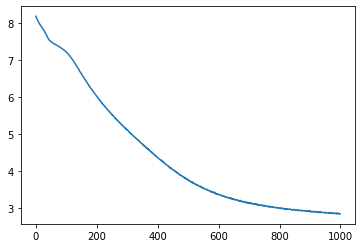

In [0]:
plt.plot(history);

In [0]:
def pred_test(net, test):
  net.train(False)
  test_loader = torch.utils.data.DataLoader(test, batch_size=test[0].shape[0], num_workers=1)

  test_output, test_labels = [(net(x.float()), y) for x, y in test_loader][0]
  predicted_class = test_output.max(dim = 1)[1] 

  print("{:3.4}".format((predicted_class == np.argmax(test_labels, axis=1)).float().mean().item()))

In [0]:
pred_test(net, torch_test)

0.3376
